In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [59]:
data_test = pd.read_csv('merge_data_2020.csv')
data_train = pd.read_csv('merge_data.csv')

In [60]:
X_train = data_train.drop(['AWS', 'Row Position', 'Column Position', 'DEM'], axis=1)
y_train = data_train['AWS']
X_test = data_test.drop(['AWS', 'Row Position', 'Column Position', 'DEM'], axis=1)
y_test = data_test['AWS']

In [61]:
# Stepwise regression function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [62]:
# Select features using stepwise selection
selected_features = stepwise_selection(X_train, y_train)

# Fit the model using selected features
model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()
# Print model summary
print(model.summary())

Add  TCWV                           with p-value 0.0
Add  Imerg                          with p-value 0.0
Add  name                           with p-value 1.09e-114
Add  TCLW                           with p-value 2.14829e-80
Add  SLHF                           with p-value 2.18532e-20
                            OLS Regression Results                            
Dep. Variable:                    AWS   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1004.
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        16:00:20   Log-Likelihood:            -1.1911e+05
No. Observations:               40000   AIC:                         2.382e+05
Df Residuals:                   39995   BIC:                         2.383e+05
Df Model:                           4                                         
Co

In [63]:
# Predict on the test set
y_pred = model.predict(sm.add_constant(X_test[selected_features]))
print(y_pred)

0        1.265708
1       -0.039879
2       -0.022801
3        0.753264
4       -0.368251
           ...   
99995    0.575189
99996    1.188314
99997    1.350645
99998    1.297383
99999    0.871802
Length: 100000, dtype: float64


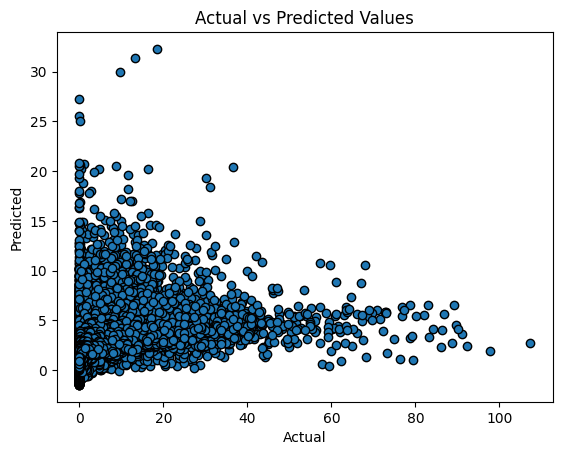

In [64]:
import matplotlib.pyplot as plt
# Plotting the actual vs predicted values
# plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()